In [1083]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.colors as col
import numpy as np
import scipy as sp
import pandas as pd
import time

from bisect import bisect_left
from copy import deepcopy

## To do:

* Fix cars fusing from different lanes

In [1112]:
class TrafficSimulation():
    
    def __init__(self,road_size,lanes,density, p_change = 1):
        global cars
        
        self.road_size = road_size
        self.density = density
        self.time_step = 0
        self.lanes = lanes
        self.n_cars = round(self.road_size * self.density)
        self.road = -1*np.ones((lanes,road_size))
        self.states = []
        self.p_change = p_change
        
        self.initial_positions = np.random.choice(range(self.road_size),self.n_cars,replace=False)
            
        cars = [Car(id=i, position = np.array([lanes-1,initial_positions[i]]),vmax=5, p_slow = 0) for i in range(self.n_cars)]
        
        for car in cars:
            self.road[tuple(car.position)] = car.v
        
        
        self.car_positions = []
        for l in range(self.lanes):
            #self.car_positions.append({})
            cars_in_a_lane = list(filter(lambda x : x.position[0] == l, cars))
            self.car_positions.append([car.position[1] for car in sorted(cars_in_a_lane, key = lambda x : x.position[1])])

        
    def draw(self):
        
        
        C = np.array([[255,255,255],
            [235,198,83],
            [136,230,255],
            [0,200,255],
            [0,145,255],
            [0,92,205],
            [0,57,103]])
        
        cm = col.ListedColormap(C/255.0)
        
        self.fig, self.bars = plt.subplots(1, figsize=(15,7))
        self.bars.cla()
        im = self.bars.imshow(self.road,vmin = -1, vmax = 5, cmap = cm, interpolation='none')# plt.cm.binary)
        self.bars.axis('image')
        
        if self.lanes <= 3: self.bars.get_yaxis().set_visible(False)
        else: self.bars.set_yticks(range(0,self.road.shape[0]))
        self.bars.set_xticks(range(0,self.road.shape[1]+1,2))
        self.bars.set_title('t = ' + str(self.time_step)) 
        
        if self.time_step == 0:
            cbaxes = self.fig.add_axes([0, 0.7, 0.8, 0.02]) 
            cb = plt.colorbar(self.bars.imshow(self.road,vmin = -1, vmax = 5, cmap = cm)# plt.cm.binary)
            , cax = cbaxes, orientation = 'horizontal')  
        
        
        self.fig.subplots_adjust(left=0)
        
        
    def animate(self):
        global fig, frames, ani
        fig, bars = plt.subplots(1, figsize=(9,7))
        plt.yticks([])
        plt.xticks(range(0,self.road.shape[0]+1,4))
        plt.tight_layout()

        C = np.array([[255,255,255],
            [235,198,83],
            [136,230,255],
            [0,200,255],
            [0,145,255],
            [0,92,205],
            [0,57,103]])
        
        cm = col.ListedColormap(C/255.0)
        frames = [[plt.imshow(s,animated=True,cmap=cm)] for s in self.states]
        ani = anim.ArtistAnimation(fig, frames, interval=50, blit=True,
                                        repeat_delay=1000)
        plt.show()
        
        return ani

    def update_road_map(self):
        self.car_positions = []
        for l in range(self.lanes):
            cars_in_a_lane = list(filter(lambda x : x.position[0] == l, cars))
            self.car_positions.append([car.position[1] for car in sorted(cars_in_a_lane, key = lambda x : x.position[1])])
    

    def update_simulation(self):
        
        
        self.time_step += 1

        
        
        self.update_road_map()
        
        for car in cars:
            car.change_lane()
        
        
        self.update_road_map()
        
        for car in cars:
            car.update_v()
            #print(car.v)
        
        for car in cars:
            car.update_position()
        
    
        #self.draw()
        
        self.road.fill(-1)
        for car in cars:
            self.road[tuple(car.position)] = car.v
        
        self.states.append(deepcopy(self.road))
        #print(self.states[-1] == self.states[0])
        #print(self.states[-1][:,:10]) 
        
        
#################   
        

class Car:
    
    def __init__(self, id, position, vmax, p_slow = 0.5):
        self.id = id
        self.position = position
        self.p_slow = p_slow

        
        self.v = 1
        self.vmax = vmax
        
    def periodic_distance(self,x,y,size = sim.road_size):
        return min(abs(x-y), x-y+size)
        
    def check_left(self):
        if self.position[0] == 0:
            return 0
        
        left_lane = self.position[0] - 1
        
        if len(sim.car_positions[left_lane]) == 0:
            self.left_gap = sim.road_size - 1
            return sim.road_size - 1
        
        front_idx = bisect_left(sim.car_positions[self.position[0]], self.position[1]) % len(sim.car_positions[self.position[0]])
        front_position = sim.car_positions[self.position[0]][front_idx]
        
        left_idx = bisect_left(sim.car_positions[left_lane], self.position[1]) % len(sim.car_positions[left_lane])
        left_position = sim.car_positions[left_lane][left_idx]
        
        back_idx = (left_idx - 1) % len(sim.car_positions[left_lane])
        back_position = sim.car_positions[self.position[left_lane]][back_idx]
        
        self.front_gap = self.periodic_distance(front_position, self.position[1]) - 1
        self.left_gap = self.periodic_distance(left_position, self.position[1]) -1
        self.back_gap = self.periodic_distance(back_position, self.position[1]) -1
        
        if self.front_gap < self.v + 1 and self.left_gap > self.v + 1 and self.back_gap > self.vmax:
            return self.left_gap - self.front_gap
        else:
            return 0
        
    
    def check_right(self):
        if self.position[0] == sim.lanes - 1:
            self.right_gap = sim.road_size - 1
            return 0
        
        right_lane = self.position[0] + 1
        
        if len(sim.car_positions[right_lane]) == 0:
            return sim.road_size - 1
        
        front_idx = (bisect_left(sim.car_positions[self.position[0]], self.position[1]) + 1) % len(sim.car_positions[self.position[0]])
        front_position = sim.car_positions[self.position[0]][front_idx]
        
        right_idx = bisect_left(sim.car_positions[right_lane], self.position[1]) % len(sim.car_positions[right_lane])
        right_position = sim.car_positions[right_lane][right_idx]
        
        back_idx = (right_idx - 1) % (sim.road_size)
        back_position = sim.car_positions[self.position[right_lane]][back_idx]
        
        self.front_gap = self.periodic_distance(front_position, self.position[1]) - 1
        self.right_gap = self.periodic_distance(right_position, self.position[1]) -1
        self.back_gap = self.periodic_distance(back_position, self.position[1]) -1
        
        if self.front_gap < self.v + 1 and self.right_gap > self.v + 1 and self.back_gap > self.vmax:
            return self.right_gap - self.front_gap
        else:
            return 0
                                     
    
    def change_lane(self):
        right_gain = self.check_right()
        left_gain = self.check_left()
        
        if right_gain == 0 and left_gain == 0:
            return
        elif right_gain > left_gain:
            if np.random.random() < sim.p_change:
                self.position += np.array([1,0])
        elif left_gain > right_gain:
            if np.random.random() < sim.p_change:
                self.position -= np.array([1,0])
        elif right_gain == left_gain:
            if np.random.random() < sim.p_change:
                self.position +=[np.random.choice([1,-1]),0]
        
        
    def update_v(self):
        front_idx = (bisect_left(sim.car_positions[self.position[0]], self.position[1]) + 1) % len(sim.car_positions[self.position[0]])
        #print('front index: ',front_idx)
        front_position = sim.car_positions[self.position[0]][front_idx]

        #print('front position :',front_position,' self position:',self.position[1])
        self.front_gap = self.periodic_distance(front_position, self.position[1]) - 1
        
        if self.front_gap < 0:
            print('Car {} has crashed at position {} at time {}'.format(self.id, self.position, sim.time_step))
        #print('gap :',self.front_gap)
        
        if self.v < self.vmax: # rule 1
            self.v += 1
        
        if self.v > self.front_gap: # rule 2
            self.v = self.front_gap
        
        if self.v > 0 and np.random.random() < self.p_slow: #rule 3
            self.v -= 1
    
    def update_position(self):   
        self.position = (self.position + np.array([0, self.v])) % sim.road_size
        
        front_idx = (bisect_left(sim.car_positions[self.position[0]], self.position[1]) + 1) % len(sim.car_positions[self.position[0]])
        #print('front index: ',front_idx)
        front_position = sim.car_positions[self.position[0]][front_idx]
        
        #print('front position :',front_position,' self position:',self.position[1])
        self.front_gap = self.periodic_distance(front_position, self.position[1]) - 1
        
        #if cars[self.front_car].
        
        



/Users/nico/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


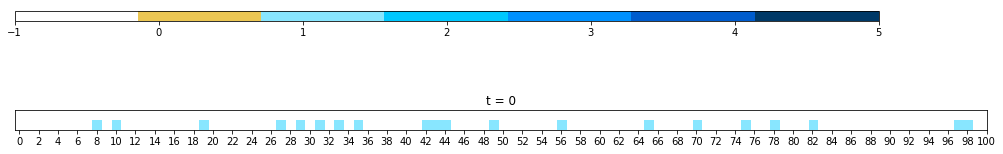

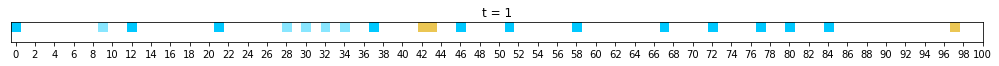

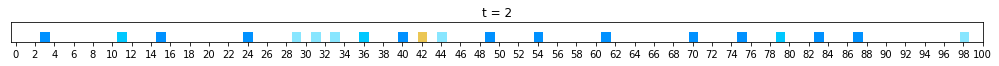

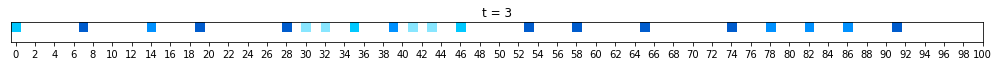

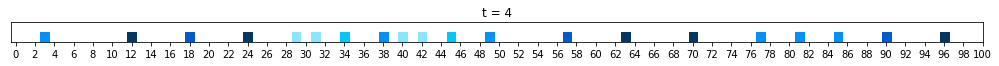

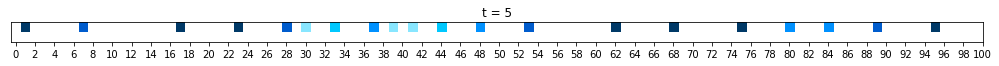

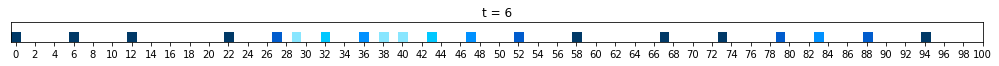

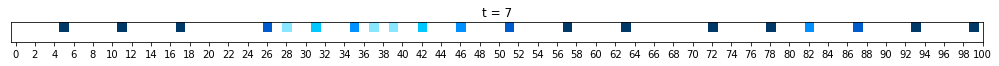

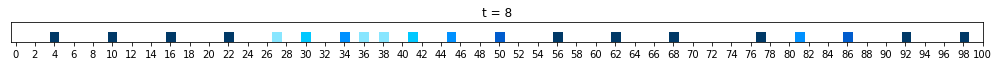

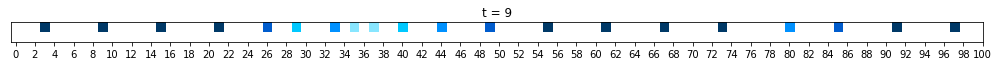

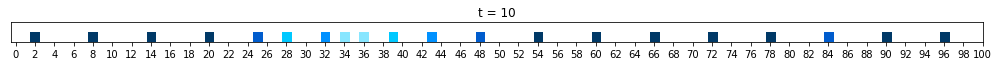

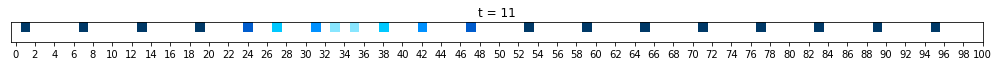

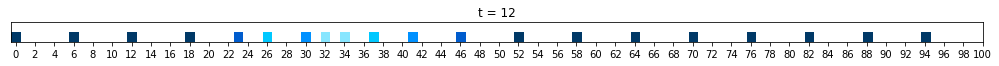

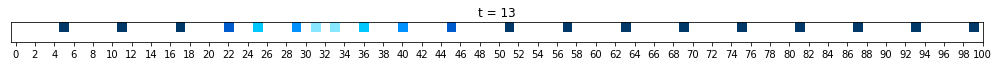

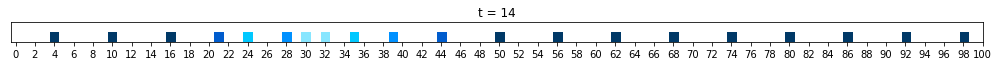

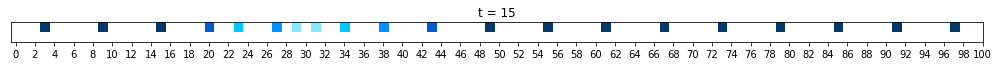

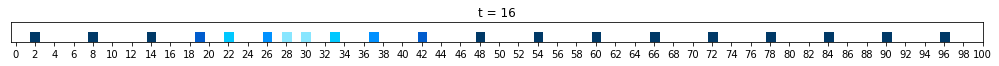

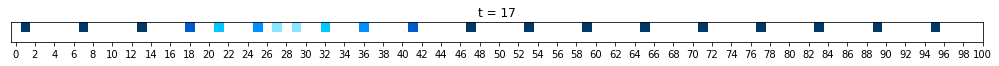

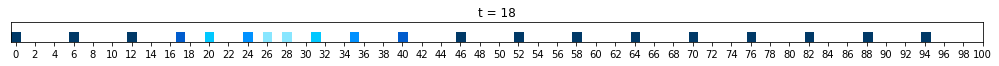

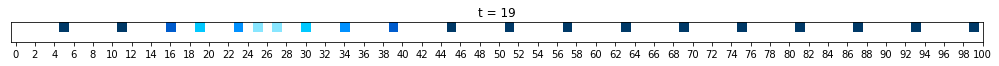

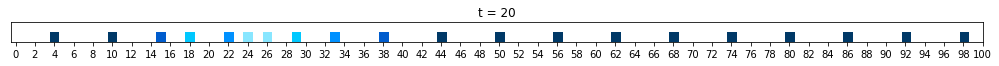

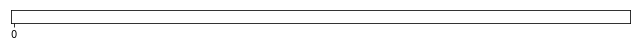

In [1116]:
sim = TrafficSimulation(road_size = 100,lanes=2,density = 0.2, p_change= 1)
sim.draw()

for _ in range(20):
    sim.update_simulation()
    sim.draw()


    
sim.animate()

Writer = anim.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)
ani.save('traffic2d_simulation.mp4',writer=writer)

#print(sim.time_step,[(tuple(car.position),car.front_gap) for car in cars])
    #print('\n')
    #sim.draw()

In [1047]:
# sim = TrafficSimulation(road_size = 100,lanes=2,density = 0.4)
# sim.draw()

# for _ in range(20):
#     sim.update_simulation()
#     sim.draw()
#     #print(sim.time_step,[(tuple(car.position),car.front_gap) for car in cars])
#     #sim.draw()

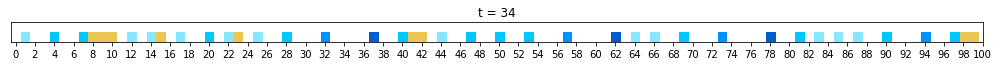

In [1065]:
sim.update_simulation()
sim.draw()

In [1080]:
sim.states[0]==sim.states[-1]

#print('\n'.join(''.join('.' if x == -1 else str(x) for x in row) for row in sim.road) + "\n")
# bisect_left(sim.car_positions[cars[0].position[0]], cars[0].position[1]) % (sim.road_size-1)

# sim.car_positions[0]

# print(sim.car_positions[3])
# position_front = bisect_left(sim.car_positions[3], 40)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  Tru

In [964]:
cars[0].position, 'v=', cars[0].v, 'front gap: ', cars[0].front_gap, 'other gap: ', cars[0].left_gap

(array([ 2, 55]), 'v=', 0, 'front gap: ', 23, 'other gap: ', 99)

In [523]:
cars[0].front_gap < cars[0].v + 1 and cars[0].other_gap > cars[0].v + 1 #and cars[0].back_gap > cars[0].vmax

False

In [784]:
sim.car_positions[cars[0].position[0]][10]
#bisect_left(sim.car_positions[cars[0].position[0]], 120)

IndexError: list index out of range

In [452]:
(np.array([1,2]) + np.array([2,4])) % (3,1)

array([0, 0])

In [298]:
list(map(lambda x : x.id,list(filter(lambda x : x.lane == 1, cars))))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [281]:
[x.lane for x in cars]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [414]:
example_list = np.array([0,70])
#print(*example_list)
sim.road[tuple(example_list)]
#(np.array([1,2]) + np.array([2,4])) % 4

-1.0

In [685]:
-1 % 100

# road_size = 100
# density = 0.4
# n_cars = round(road_size * density)

# road = -1*np.ones(road_size)

# initial_positions = np.random.choice(range(road_size),n_cars,replace=False)

# cars = [Car(id=i, position= initial_positions[i],vmax=5) for i in range(n_cars)]
# sorted_ids = np.array([car.id for car in sorted(cars, key = lambda x : x.position)])



# print(road)

# for t in range(4):
#     for car in cars:
#         car.update_panorama()
#         car.update_v()
#         car.update_position()

#         road[car.position] = car.v

#     print(road)




# # for i,j in enumerate(sorted_ids):
# #     cars[j].front_car = sorted_ids[(i+1) % n_cars]
# #     cars[j].back_car = sorted_ids[(i-1) % n_cars]


# #     if cars[cars[j].front_car].position > cars[j].position:
# #         cars[j].front_gap = cars[cars[j].front_car].position - cars[j].position - 1
# #     else:
# #         cars[j].front_gap = road_size + (cars[cars[j].front_car].position - cars[j].position) - 1
    

# #     road[cars[j].position] = cars[j].v
    
# # print(road)
    

99

In [1019]:
sim.states[2]

array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1.,  1., -1., -1.,  2., -1., -1., -1.,  3., -1., -1.,  2.,  0.,
         0., -1.,  1., -1., -1.,  2., -1., -1.,  2.,  0.,  0.,  0., -1.,
         1., -1.,  1.,  0., -1.,  1., -1., -1.,  2., -1.,  1.,  0., -1.,
         1., -1., -1.,  2., -1., -1., -1.,  3., -1., -1., -1., -1.,  4.,
        -1., -1.,  2.,  0.,  0., -1.,  1., -1., -1.,  2., -1., -1.,  2.,
        -1., -1.,  2., -1., -1., -1.,  3., -1., -1., -1., -1.,  4., -1

TypeError: draw() takes 0 positional arguments but 1 was given

In [698]:
a = np.array([0,5])

In [699]:
a-=np.array([1,0])

In [742]:
[np.random.choice([1,-1]),0]

[1, 0]

In [794]:
[][0]

IndexError: list index out of range

In [1098]:
sim.states[-6][:,:10]

array([[ 2., -1.,  1., -1.,  1., -1.,  1., -1., -1.,  2.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])